In [1]:
import pandas as pd
import numpy as np
import numpy as np
from scipy.optimize import minimize
import pandas_datareader.data as reader
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from scipy import optimize
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


In [3]:
df = pd.read_csv('../test_datasets/Actual.csv')
shares_outstanding = df.iloc[0]
df.drop(0, inplace=True)


In [4]:
df

,Unnamed: 0,A,B,C,D,E,F,G,H,I
1,1,144.935575,227.882208,145.000811,78.897964,139.777286,33.608131,172.101489,305.086648,3101.989323
2,2,144.437134,234.666980,149.455145,81.378646,137.287929,33.521216,173.138616,304.388169,3134.173443
3,3,139.034096,231.480569,146.563009,83.680871,140.464937,32.373154,166.264334,300.779456,3122.525940
4,4,141.213983,233.275829,147.956318,79.816857,134.809211,31.813596,167.837537,312.957644,3134.811377
5,5,140.265180,233.666948,148.002211,79.925794,131.878987,31.827753,172.665026,324.526982,3108.174691
...,...,...,...,...,...,...,...,...,...,...
2504,2504,1297.164867,2994.203816,686.117089,62.320904,78.924931,113.435158,4456.158943,21357.880970,127459.822000
2505,2505,1291.161511,2938.950066,674.352204,62.961496,77.684331,109.623823,4515.854224,22519.939970,127735.030200
2506,2506,1289.726586,2910.861481,673.740238,62.632459,77.276593,107.954424,4682.722399,22005.634000,129251.684400
2507,2507,1291.052193,2985.814154,686.296262,64.223488,79.928203,113.039260,4853.785794,22499.341580,122875.124800


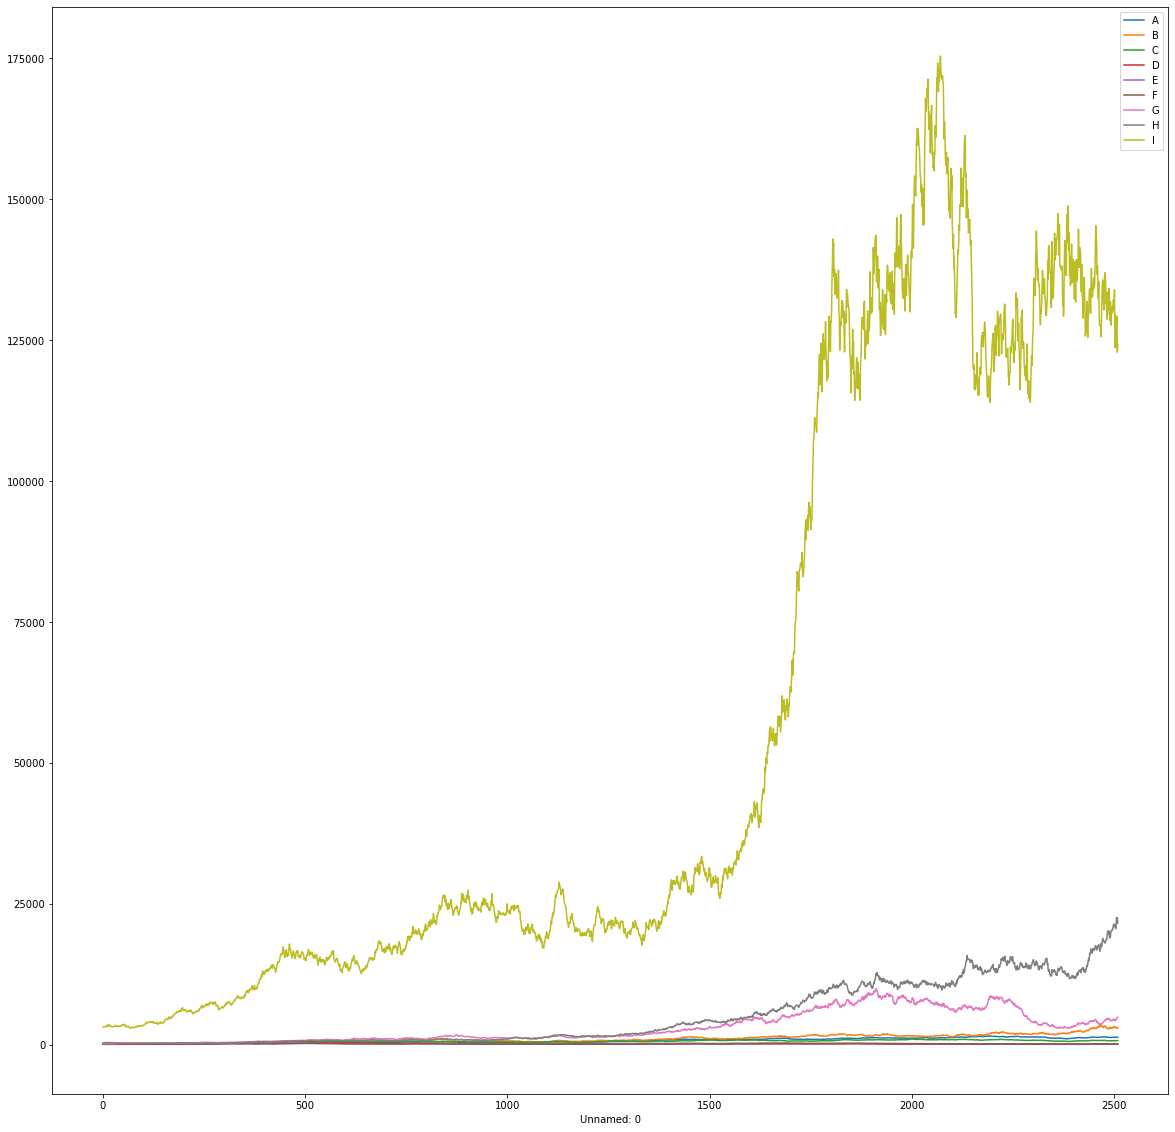

In [5]:
df.plot(x='Unnamed: 0', y=[i for i in df.columns[1:]], kind="line", figsize=(20,20))
plt.show()

In [9]:
vars = {}
for i in [i for i in df.columns[1:]]:
  ticker = df[i]
  var = ticker.pct_change().var()
  
  vars[i] = var


vardf = pd.DataFrame().from_dict(vars, orient='index').to_numpy().flatten()

print(list(np.argsort(vardf)))

[0, 2, 8, 1, 7, 6, 3, 5, 4]


https://michael-fuchs-python.netlify.app/2020/10/27/time-series-analysis-regression-extension-techniques-for-forecasting-univariate-variables/

In [10]:
 def MaximizeSharpeRatioOptmzn(self, MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):

        # define maximization of Sharpe Ratio using principle of duality
        def f(x, MeanReturns, CovarReturns, RiskFreeRate, PortfolioSize):
            funcDenomr = np.sqrt(np.matmul(np.matmul(x, CovarReturns), x.T))
            funcNumer = np.matmul(np.array(MeanReturns), x.T)-RiskFreeRate
            func = -(funcNumer / funcDenomr)
            return func

        # define equality constraint representing fully invested portfolio
        def constraintEq(x):
            A = np.ones(x.shape)
            b = 1
            constraintVal = np.matmul(A, x.T)-b
            return constraintVal

        # define bounds and other parameters
        xinit = np.repeat(0.33, PortfolioSize)
        cons = ({'type': 'eq', 'fun': constraintEq})
        lb = 0
        ub = 1
        bnds = tuple([(lb, ub) for x in xinit])

        # invoke minimize solver
        opt = optimize.minimize(f, x0=xinit, args=(MeanReturns, CovarReturns,
                                                   RiskFreeRate, PortfolioSize), method='SLSQP',
                                bounds=bnds, constraints=cons, tol=10**-3)

        return opt

In [5]:
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()

corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()

ind_er = df.pct_change().mean()

ann_sd = df.pct_change().std().apply(lambda x: x*np.sqrt(250))

In [8]:
cov_matrix

,Unnamed: 0,A,B,C,D,E,F,G,H,I
Unnamed: 0,3.800290e-04,0.000002,-0.000007,-0.000002,2.491419e-07,0.000022,-0.000007,0.000014,-0.000008,-0.000004
A,2.348307e-06,0.010819,-0.001432,0.000272,-6.637457e-04,0.001654,0.000273,0.002349,-0.001222,0.002396
B,-6.721044e-06,-0.001432,0.009731,-0.000870,-2.708758e-04,-0.003143,0.001371,-0.002760,0.002905,-0.001399
C,-1.716628e-06,0.000272,-0.000870,0.009513,-1.872268e-03,0.002140,-0.002910,0.002537,-0.003427,0.001142
D,2.491419e-07,-0.000664,-0.000271,-0.001872,1.377888e-02,-0.001590,0.004688,-0.001970,0.002914,-0.002130
E,2.198853e-05,0.001654,-0.003143,0.002140,-1.589835e-03,0.012253,0.000416,0.001235,-0.003353,0.001144
F,-6.603658e-06,0.000273,0.001371,-0.002910,4.687850e-03,0.000416,0.014133,-0.001909,0.003862,-0.001541
G,1.364879e-05,0.002349,-0.002760,0.002537,-1.969509e-03,0.001235,-0.001909,0.013672,-0.002364,0.000977
H,-8.157791e-06,-0.001222,0.002905,-0.003427,2.913913e-03,-0.003353,0.003862,-0.002364,0.012153,-0.003488
I,-3.906802e-06,0.002396,-0.001399,0.001142,-2.130295e-03,0.001144,-0.001541,0.000977,-0.003488,0.007661


In [9]:
log_returns = np.log(df/df.shift(1))



portfolio_returns = []
portfolio_volatilities = []
for x in range(1000):
    weights = np.random.random(len(df.columns[1:]))
    weights /= np.sum(weights)
    
    portfolio_returns.append(np.sum(weights * log_returns.mean()) * 250)
    portfolio_volatilities.append(np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 250, weights))))
                    
portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)
                                  
portfolio_returns, portfolio_volatilities